In [1]:
import pandas as pd
from datetime import datetime
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Embedding, concatenate, Input, average, Bidirectional, BatchNormalization, Activation, Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from matplotlib import pyplot as plt

def metrics(predictions, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f'Verdaderos Negativos: {tn}')
    print(f'Falsos Negativos: {fn}')
    print(f'Verdaderos Positivos: {tp}')
    print(f'Falsos Positivos: {fp}')
    print()
    print(f'precision score: {precision_score(y_test, predictions)}')
    print(f'recall score: {recall_score(y_test, predictions)}')
    print(f'f1 score: {f1_score(y_test,  predictions)}')

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
url_train = 'https://raw.githubusercontent.com/fsicardir/datos-tp2/master/dataset/train.csv?token=AFVAIUW66UE3NA5X2SYXNPC7GHGJY'
url_test = 'https://raw.githubusercontent.com/fsicardir/datos-tp2/master/dataset/test.csv?token=AFVAIUUSBVEOOMDIFV4GU6C7GHGNK'

read_train = pd.read_csv(url_train)
read_test = pd.read_csv(url_test)

In [3]:
!wget -c http://nlp.stanford.edu/data/glove.twitter.27B.zip
#!unzip glove.twitter.27B.zip

--2020-08-07 19:36:21--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-08-07 19:36:21--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-08-07 19:36:21--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

  

In [4]:
# Créditos a este notebook https://www.kaggle.com/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}


def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [5]:
# Esta lista de contractions la obtuvimos de un notebook de Kaggle también, el cual pone como fuente al siguiente
# post de stackoverflow http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"thx"   : "thanks"
}


def remove_contractions(text):
    return contractions[text.lower()] if text.lower() in contractions.keys() else text

In [6]:
df_train = read_train[['id', 'text', 'keyword', 'target']]
df_test = read_test[['id', 'text', 'keyword']]
df_train['keyword'].fillna("", inplace=True)
df_test['keyword'].fillna("", inplace=True)
df_train['keyword'] = df_train['keyword'].apply(lambda x: x.replace("%20", " "))
df_test['keyword'] = df_test['keyword'].apply(lambda x: x.replace("%20", " "))

# Limpiamos los datos de la forma usual
# Quitamos las urls
df_train['text'] = df_train['text'].str.replace(r'http:\/\/.*', '', regex=True).replace(r'https:\/\/.*', '', regex=True)
df_test['text'] = df_test['text'].str.replace(r'http:\/\/.*', '', regex=True).replace(r'https:\/\/.*', '', regex=True)

# Quitamos user mentions, signos de puntuación, hashtags y stopwords.
def clean_text(text):
    words = text.lower().split(' ')
    words = [convert_abbrev(word) for word in words]
    words = [remove_contractions(word) for word in words]
    text = ' '.join([word for word in words if not word.startswith('@') and word not in stopwords.words('english')])
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

keywords_train = df_train['keyword'].tolist()
keywords_test = df_test['keyword'].tolist()

train_tweets = df_train['text'].tolist()
train_target = df_train['target']
test_tweets = df_test['text'].tolist()
len(train_tweets), len(train_target), len(test_tweets)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

(7613, 7613, 3263)

In [7]:
# Cargamos los embeddings de GloVe. Utilizaremos los de 200 dimensiones.
glove_dict = {}
with open('glove.twitter.27B.100d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], dtype='float32')
      glove_dict[word] = vector

In [9]:
# Para los embeddings de las palabras de los tweets.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweets)
vocabulary_size = len(tokenizer.word_index) + 1

# Para los embeddings de los keywords
key_tokenizer = Tokenizer()
key_tokenizer.fit_on_texts(keywords_train)
keywords_vocab_size = len(key_tokenizer.word_index) + 1
# Tenemos keywords con dos palabras.
key_padding = 2

sequences_train = tokenizer.texts_to_sequences(train_tweets)
sequence_test = tokenizer.texts_to_sequences(test_tweets)
keywords_seq_train = key_tokenizer.texts_to_sequences(keywords_train)
keywords_seq_test = key_tokenizer.texts_to_sequences(keywords_test)

max_padding = 25
padded_vecs_train = pad_sequences(sequences_train, maxlen=max_padding, padding='post')
padded_vecs_test = pad_sequences(sequence_test, maxlen=max_padding, padding='post')
padded_keywords_train = pad_sequences(keywords_seq_train, maxlen=key_padding, padding='post')
padded_keywords_test = pad_sequences(keywords_seq_test, maxlen=key_padding,  padding='post')

# Ahora vamos a crear una matriz que tendrá los embeddings de GloVe
# correspondientes a cada palabra de nuestro vocabulario.
# Esto se lo pasaremos como pesos a la capa de Embedding del modelo a entrenar.
embedding_dim = 100
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_dict.get(word, None)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

keyword_emb_matrix = np.zeros((keywords_vocab_size, embedding_dim))
for word, i in key_tokenizer.word_index.items():
    embedding_vector = glove_dict.get(word, None)
    if embedding_vector is not None:
        keyword_emb_matrix[i] = embedding_vector

In [10]:
vocabulary_size, keywords_vocab_size

(15363, 230)

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 25, 100)      1536300     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 21, 100)      50100       embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 22, 100)      40100       embedding_10[0][0]               
______________________________________________________________________________________

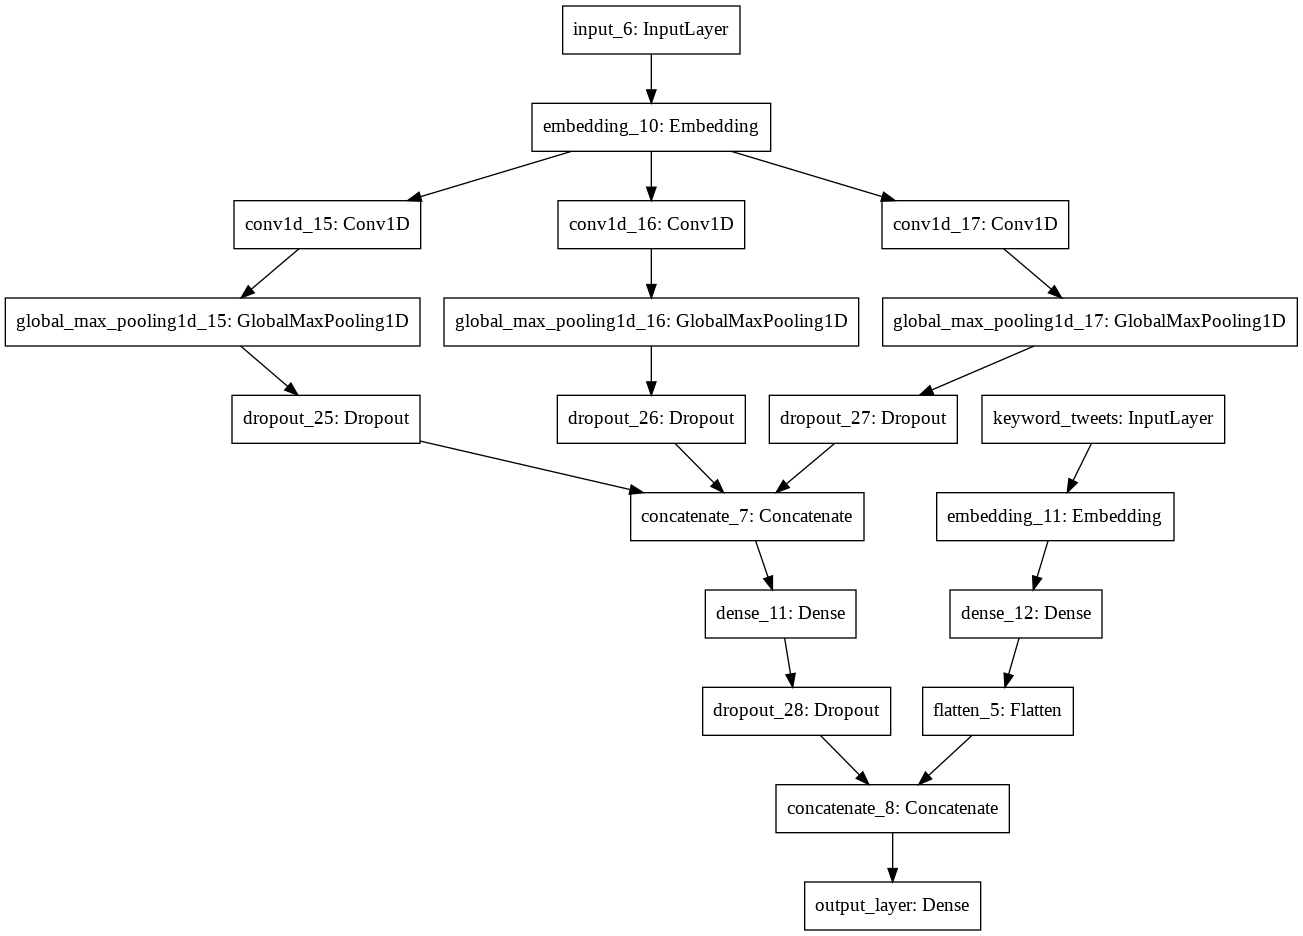

In [26]:
# Modelo para los tweets basado en algunas recomendaciones de este paper https://arxiv.org/pdf/1510.03820.pdf

n_filters = 100

input_text = Input(shape=(max_padding))
emb_text = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_padding, trainable=False)(input_text)

conv1 = Conv1D(n_filters, 5, activation='relu')(emb_text)
conv1 = GlobalMaxPooling1D()(conv1)
conv1 = Dropout(0.5)(conv1)

conv2 = Conv1D(n_filters, 4, activation='relu')(emb_text)
conv2 = GlobalMaxPooling1D()(conv2)
conv2 = Dropout(0.5)(conv2)

conv3 = Conv1D(n_filters, 3, activation='relu')(emb_text)
conv3 = GlobalMaxPooling1D()(conv3)
conv3 = Dropout(0.5)(conv3)

concat_conv_out = concatenate([conv1, conv2, conv3])

conv_out = Dense(64, activation='relu')(concat_conv_out)
conv_out = Dropout(0.5)(conv_out)

model_conv = Model(input_text, conv_out)

# Modelo para los keywords
input_keys = Input(shape=(key_padding), name='keyword_tweets')
emb_keys = Embedding(input_dim=keywords_vocab_size, output_dim=embedding_dim, weights=[keyword_emb_matrix], input_length=key_padding, trainable=False)(input_keys)
keys_out = Dense(32, activation='relu')(emb_keys)
keys_out = Flatten()(keys_out)
model_keys = Model(input_keys, keys_out)

concatenated = concatenate([conv_out, keys_out])
out = Dense(1, activation='sigmoid', name='output_layer')(concatenated)

merged_model = Model([input_text, input_keys], out)
merged_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m])
merged_model.summary()
plot_model(merged_model)

In [27]:
history = merged_model.fit([padded_vecs_train, padded_keywords_train], y=train_target, epochs=5, verbose=1, validation_split=0.2, shuffle=True)

Epoch 1/5
191/191 [==============================] - 4s 20ms/step - loss: 0.5556 - accuracy: 0.7228 - f1_m: 0.6490 - val_loss: 0.4586 - val_accuracy: 0.7919 - val_f1_m: 0.5983
Epoch 2/5
191/191 [==============================] - 4s 21ms/step - loss: 0.4503 - accuracy: 0.8000 - f1_m: 0.7378 - val_loss: 0.4238 - val_accuracy: 0.8142 - val_f1_m: 0.6740
Epoch 3/5
191/191 [==============================] - 3s 18ms/step - loss: 0.4194 - accuracy: 0.8179 - f1_m: 0.7581 - val_loss: 0.4264 - val_accuracy: 0.8070 - val_f1_m: 0.6398
Epoch 4/5
191/191 [==============================] - 4s 22ms/step - loss: 0.3848 - accuracy: 0.8333 - f1_m: 0.7818 - val_loss: 0.4167 - val_accuracy: 0.8129 - val_f1_m: 0.6635
Epoch 5/5
191/191 [==============================] - 4s 21ms/step - loss: 0.3644 - accuracy: 0.8475 - f1_m: 0.8023 - val_loss: 0.4241 - val_accuracy: 0.8194 - val_f1_m: 0.6668


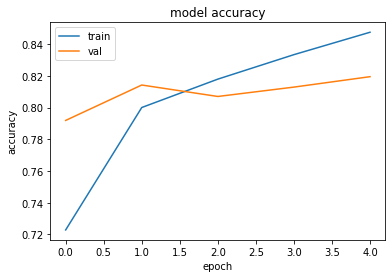

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

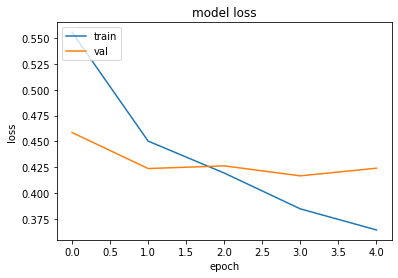

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
preds = merged_model.predict([padded_vecs_test, padded_keywords_test])


In [31]:
kaggle_pred = [1 if x >= 0.5 else 0 for x in preds]

results = df_test[['id']]
results['target'] = kaggle_pred
results.to_csv('cnn-keywords-glove-v2.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
